In [14]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.interpolate import griddata

In [15]:
results = []
json_file = 'grasping_position_cm_offset_results/result.json'
with open(json_file, "r") as file:
    results = json.load(file)
for i in range(len(results)):
    for j in range(len(results[0])):
        if isinstance(results[i][j], float):
            results[i][j] = round(results[i][j], 4)

In [25]:
final_results = {}
for a, _, b, _, c in results:
    a = round(a, 3)
    b = round(b, 3)
    x = str(a) + '_' + str(b)

    if x in final_results:
        final_results[x].append(c)
    else:
        final_results[x] = [c]

for key, value in final_results.items():
    #final_results[key] = sum(value)/len(value)
    final_results[key] = max(value)
final_results



{'0.01_0.01': 0.1602,
 '0.014_0.01': 0.8183,
 '0.014_0.023': 0.6781,
 '0.011_0.011': 0.1545,
 '0.015_0.01': 0.8192,
 '0.015_0.024': 0.2463,
 '0.012_0.012': 0.1445,
 '0.016_0.01': 0.8197,
 '0.016_0.025': 0.2539,
 '0.013_0.013': 0.1365,
 '0.016_0.026': 0.265,
 '0.014_0.014': 0.1424,
 '0.017_0.011': 0.8187,
 '0.017_0.027': 0.283,
 '0.015_0.015': 0.1368,
 '0.018_0.011': 0.8192,
 '0.018_0.028': 0.262}

In [26]:
sorted(final_results.items(), key = lambda x: x[1])

[('0.013_0.013', 0.1365),
 ('0.015_0.015', 0.1368),
 ('0.014_0.014', 0.1424),
 ('0.012_0.012', 0.1445),
 ('0.011_0.011', 0.1545),
 ('0.01_0.01', 0.1602),
 ('0.015_0.024', 0.2463),
 ('0.016_0.025', 0.2539),
 ('0.018_0.028', 0.262),
 ('0.016_0.026', 0.265),
 ('0.017_0.027', 0.283),
 ('0.014_0.023', 0.6781),
 ('0.014_0.01', 0.8183),
 ('0.017_0.011', 0.8187),
 ('0.015_0.01', 0.8192),
 ('0.018_0.011', 0.8192),
 ('0.016_0.01', 0.8197)]

In [20]:
str(0.011)

'0.011'

In [16]:
sorted(results, key = lambda x : x[4])

[[0.012, 0.0, 0.012, 'U', 0.0054],
 [0.011, 0.0, 0.011, 'U', 0.0055],
 [0.01, 0.0, 0.01, 'U', 0.0058],
 [0.014, 0.0, 0.014, 'U', 0.0063],
 [0.013, 0.0, 0.013, 'U', 0.0072],
 [0.015, 0.0, 0.015, 'U', 0.008],
 [0.015, 0.0, 0.015, "U'", 0.0098],
 [0.015, 0.0, 0.015, "U'", 0.0105],
 [0.01, 0.0, 0.01, "U'", 0.011],
 [0.014, 0.0, 0.014, "U'", 0.0128],
 [0.013, 0.0, 0.013, "U'", 0.0132],
 [0.011, 0.0, 0.011, "U'", 0.0133],
 [0.012, 0.0, 0.012, "U'", 0.0133],
 [0.01, 0.0, 0.01, "U'", 0.0161],
 [0.0141, 0.0224, 0.01, "F'", 0.0181],
 [0.014, 0.0, 0.014, "U'", 0.0196],
 [0.011, 0.0, 0.011, "U'", 0.0201],
 [0.018, 0.0224, 0.0112, 'F', 0.0205],
 [0.0141, 0.0224, 0.01, 'F', 0.0215],
 [0.011, 0.0, 0.011, 'U', 0.0228],
 [0.012, 0.0, 0.012, 'U', 0.0235],
 [0.0172, 0.0224, 0.0108, 'F', 0.0261],
 [0.01, 0.0, 0.01, 'U', 0.0268],
 [0.018, 0.0229, 0.028, 'R', 0.0273],
 [0.012, 0.0, 0.012, "U'", 0.0274],
 [0.0164, 0.0224, 0.0104, 'F', 0.028],
 [0.0149, 0.0224, 0.01, 'F', 0.0281],
 [0.0156, 0.0224, 0.0102, 'F

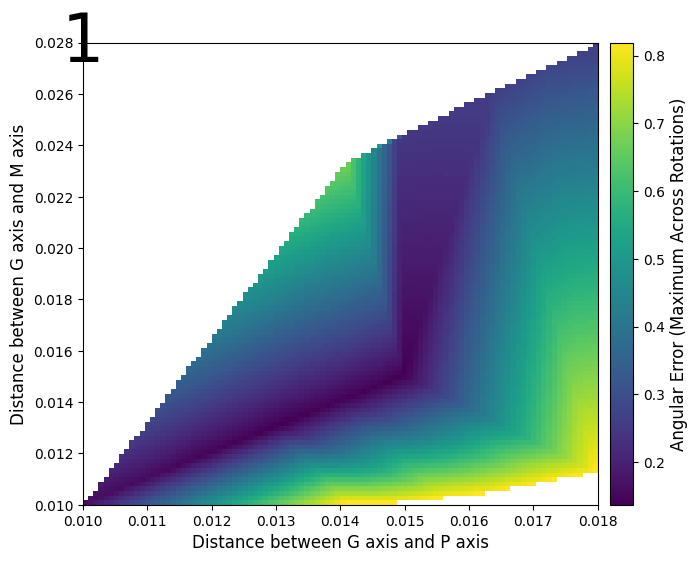

In [17]:
# Data (Replace `results` with your actual data)
data = results

# pg_distance = get_length(grip_coordinates)# pivot to grapsing center
# pm_distance = get_length(cm_coordinates)# pivot to center of mass 
# gm_distance = get_length(relative_coordinates)# grapsing center to center of mass


# Extract components
distance_pg = np.array([entry[0] for entry in data])
distance_mg = np.array([entry[2] for entry in data])
rotations = np.array([entry[3] for entry in data])
error = np.array([entry[4] for entry in data])

# Aggregate maximum error for each (friction, spacing)
# Group errors by unique (friction, spacing) pairs
unique_pairs = list(set(zip(distance_pg, distance_mg)))
max_error_per_pair = {
    pair: max(error[(distance_pg == pair[0]) & (distance_mg == pair[1])])
    for pair in unique_pairs
}

# Prepare data for interpolation
distance_pg_unique = np.array([pair[0] for pair in unique_pairs])
distance_mg_unique = np.array([pair[1] for pair in unique_pairs])
error_max = np.array([max_error_per_pair[pair] for pair in unique_pairs])

# Set up the grid for heatmap
distance_pg_grid = np.linspace(min(distance_pg), max(distance_pg), 100)
distance_mg_grid = np.linspace(min(distance_mg), max(distance_mg), 100)
grid_x, grid_y = np.meshgrid(distance_pg_grid, distance_mg_grid)

# Interpolate the maximum error for the grid
grid_z = griddata(
    (distance_pg_unique, distance_mg_unique), error_max,
    (grid_x, grid_y), method='linear'
)

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.imshow(
    grid_z,
    extent=[
        min(distance_pg), max(distance_pg),
        min(distance_mg), max(distance_mg)
    ],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

# Add title and axis labels
#ax.set_title('Heatmap of Average Angular Error Across Rotations', fontsize=14)
ax.set_xlabel('Distance between G axis and P axis', fontsize=12)
ax.set_ylabel('Distance between G axis and M axis', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Angular Error (Maximum Across Rotations)', fontsize=12)

# Save the figure
plt.text(0, 1, '1',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
     size = 48,
     color = 'black')
# plt.savefig('maximum_error_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
def avg(x) : return sum(x) / len(x)

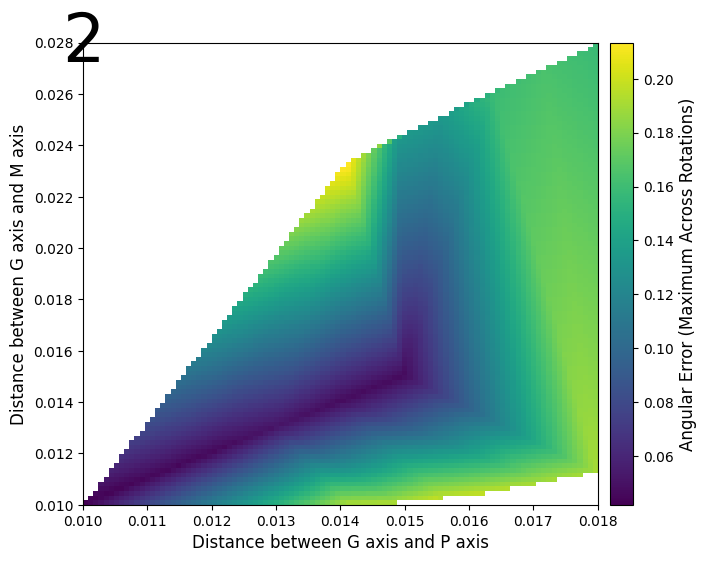

In [19]:
# Data (Replace `results` with your actual data)
data = results

# pg_distance = get_length(grip_coordinates)# pivot to grapsing center
# pm_distance = get_length(cm_coordinates)# pivot to center of mass 
# gm_distance = get_length(relative_coordinates)# grapsing center to center of mass


# Extract components
distance_pg = np.array([entry[0] for entry in data])
distance_mg = np.array([entry[2] for entry in data])
rotations = np.array([entry[3] for entry in data])
error = np.array([entry[4] for entry in data])

# Aggregate maximum error for each (friction, spacing)
# Group errors by unique (friction, spacing) pairs
unique_pairs = list(set(zip(distance_pg, distance_mg)))
max_error_per_pair = {
    pair: avg(error[(distance_pg == pair[0]) & (distance_mg == pair[1])])
    for pair in unique_pairs
}

# Prepare data for interpolation
distance_pg_unique = np.array([pair[0] for pair in unique_pairs])
distance_mg_unique = np.array([pair[1] for pair in unique_pairs])
error_max = np.array([max_error_per_pair[pair] for pair in unique_pairs])

# Set up the grid for heatmap
distance_pg_grid = np.linspace(min(distance_pg), max(distance_pg), 100)
distance_mg_grid = np.linspace(min(distance_mg), max(distance_mg), 100)
grid_x, grid_y = np.meshgrid(distance_pg_grid, distance_mg_grid)

# Interpolate the maximum error for the grid
grid_z = griddata(
    (distance_pg_unique, distance_mg_unique), error_max,
    (grid_x, grid_y), method='linear'
)

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.imshow(
    grid_z,
    extent=[
        min(distance_pg), max(distance_pg),
        min(distance_mg), max(distance_mg)
    ],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

# Add title and axis labels
#ax.set_title('Heatmap of Average Angular Error Across Rotations', fontsize=14)
ax.set_xlabel('Distance between G axis and P axis', fontsize=12)
ax.set_ylabel('Distance between G axis and M axis', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Angular Error (Maximum Across Rotations)', fontsize=12)

# Save the figure
plt.text(0, 1, '2',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
     size = 48,
     color = 'black')
# plt.savefig('maximum_error_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()